In [ ]:
# Real scalar boson star or oscillaton example
# see further details in https://github.com/GRChombo/engrenage/wiki/Running-the-oscillaton-example

# restart the kernel to clear past work
# (can also do this manually from the Kernel options above)
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [1]:
# load the required python modules
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import time
import random
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# import homemade code
sys.path.append('../')
from source.rhsevolution import *                             # go here to look at how the evolution works
from source.oscillatoninitialconditions import *              # go here to change the initial conditions
from source.hamdiagnostic import *                            # go here to change the Ham constraint diagnostic
from source.Grid import *                                     # go here to look at grid

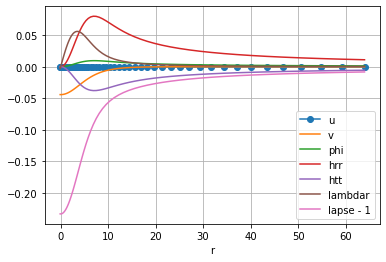

In [2]:
# Input parameters for grid and evolution here
max_r = 64.0 # outer edge of the grid (including ghosts)
num_points_r = 64 # total (including ghosts)
log_factor = 1.08 # increase in dr interval at each grid step
my_grid = Grid(max_r, num_points_r, log_factor)
r = my_grid.r_vector
initial_state = get_initial_state(my_grid)

#unpackage the vector for readability
(initial_u, initial_v , initial_phi, initial_hrr, initial_htt, initial_hpp, 
 initial_K, initial_arr, initial_att, initial_app, 
 initial_lambdar, initial_shiftr, initial_br, initial_lapse) = np.array_split(initial_state, NUM_VARS)

#plot initial conditions
plt.xlabel('r')
plt.plot(r, initial_u, '-o', label='u') # zero, but plot as dots to see the grid
plt.plot(r, initial_v, label='v')
plt.plot(r, initial_phi, label='phi')
plt.plot(r, initial_hrr, label='hrr')
plt.plot(r, initial_htt, label='htt')
plt.plot(r, initial_lambdar, label='lambdar')
#plt.plot(r, initial_shiftr, label='shiftr')
plt.plot(r, initial_lapse-1, label='lapse - 1')
plt.legend(loc='best')
plt.grid()
#plt.xlim(-0.25,5.0)
#plt.ylim(-0.0005,0.0005)

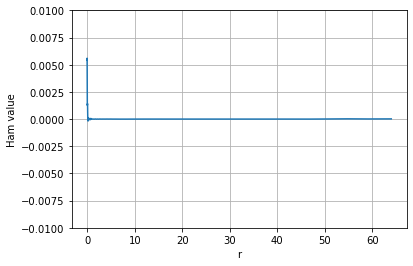

In [3]:
# check the Hamiltonian constraint initially satisfied
# apart from numerical errors
Ham = get_Ham_diagnostic(initial_state, np.array([0]), my_grid)

# plot the profile for Ham
plt.plot(r, Ham[0])

plt.xlabel('r')
#plt.xlim(-4.0,max_r)
plt.ylim(-0.01,0.01)
plt.ylabel('Ham value')
plt.grid()

In [4]:
# for control of time integrator and spatial grid
T = 20.0 # Maximum evolution time
num_points_t = 101 # time resolution (only for outputs, not for integration)

# Work out dt and time spacing of outputs
dt = T/num_points_t
t = np.linspace(0, T-dt, num_points_t)
eta = 2.0 # the 1+log slicing damping coefficient - of order 1/M_adm of spacetime

# Solve for the solution using RK45 integration of the ODE
# to make like (older) python odeint method use method='LSODA' instead
# use tqdm package to track progress
with tqdm(total=1000, unit="‰") as progress_bar:
    dense_solution = solve_ivp(get_rhs, [0,T], initial_state, 
                               args=(my_grid, eta, progress_bar, [0, T/1000]),
                        #atol=1e-5, rtol=1e-5,
                        max_step=(0.4*my_grid.base_dx), #for stability and for KO coeff of 10
                        method='RK45', dense_output=True)

# Interpolate the solution at the time points defined in myparams.py
solution = dense_solution.sol(t).T

100%|████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.22‰/s]


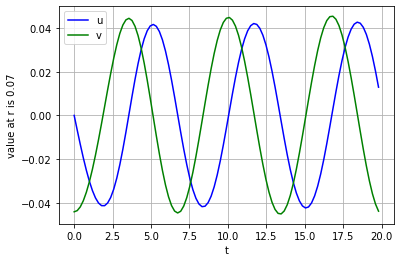

In [5]:
# Plot a single point versus time
var1 = idx_u
var2 = idx_v

idx = num_ghosts+1
r_i = np.round(r[idx],2)
var1_of_t = solution[:, var1 * num_points_r + idx]
plt.plot(t, var1_of_t, 'b-', label=variable_names[var1])
var2_of_t = solution[:, var2 * num_points_r + idx]
plt.plot(t, var2_of_t, 'g-', label=variable_names[var2])
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('value at r is '+str(r_i))
plt.legend(loc='best')
plt.grid()

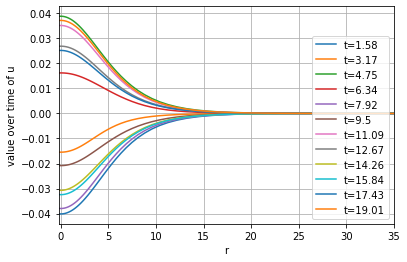

In [6]:
# plot the profile for some variable at a selection of times
var = idx_u # I suggest looking at the field u, or the lapse to see the gauge evolution

for i, t_i in enumerate(t) :
    if (i < num_points_t) and (i % 8 == 0) and (t_i > 0.0):
        labelt = "t="+str(round(t_i,2))
        f_t = solution[i, var * num_points_r: (var + 1) * num_points_r]
        plt.plot(r, f_t, label=labelt)

plt.legend(loc=4)
plt.xlabel('r')
plt.xlim(-0.2,35.0)
plt.ylabel('value over time of ' + variable_names[var])
plt.grid()

In [7]:
# calculate the diagnostics, just the Hamiltonian constraint for now
Ham = get_Ham_diagnostic(solution, t, my_grid)

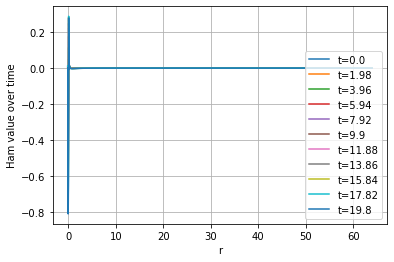

In [8]:
# plot the profile for Ham at a selection of times

for i, t_i in enumerate(t) :
    if (i < num_points_t) and (i % 10 == 0) :
        labelt = "t="+str(round(t_i,2))
        Ham_t = Ham[i]
        plt.plot(r, Ham_t, label=labelt)

plt.legend(loc=4)
plt.xlabel('r')
#plt.xlim(-1,10.0)
#plt.ylim(-1.0,1.0)
plt.ylabel('Ham value over time')
plt.grid()

In [ ]:
# Animation of the fields (u, v) varying in time
from matplotlib import animation
%matplotlib notebook

# Select variable to plot (u or v)
var_to_plot_id, var_label = idx_u, r'$u(t,r)$'
#var_to_anim_id, var_label = idx_v, r'$v(t,r)$'

# Pick it out of the solution vector
var_to_anim = solution[:, var_to_plot_id * num_points_r:var_to_plot_id * num_points_r + num_points_r]

# Set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(r[num_ghosts], r[-num_ghosts]), ylim=(1.1*np.min(var_to_anim), 1.1*np.max(var_to_anim)))
line, = plt.plot([], [], lw=2)
ax.set_xlabel(r'$r$')
ax.set_ylabel(var_label)

def init():
    line.set_data([], [])
    return line,

# Animation function. This is called sequentially
def animate(i):
    x = r[num_ghosts:-num_ghosts]
    y = var_to_anim[i]
    line.set_data(x, y)
    return line,

# Call the animator
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=np.arange(0,num_points_t,1), interval=100, blit=True)

# Display the animation interactively.
from IPython.display import HTML
HTML(anim.to_jshtml())

# Option to save the animation - requires a codec e.g. FFMPEG
#anim.save('./field_animation.mp4', writer = 'ffmpeg', fps = 20)